In [1]:
import gym
from gym.core import ObservationWrapper
from gym.spaces import Box
from scipy.misc import imresize
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import transform
from keras.layers import Conv2D, Dense, Flatten, InputLayer
import os
from IPython import display
import random
from gym.core import Wrapper
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame
import keras

Using TensorFlow backend.


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        ObservationWrapper.__init__(self, env)
        self.img_size = (64, 64, 1)
        self.observation_space = Box(0.0, 1.0, self.img_size)

    def _observation(self, img):    
        img = rgb2gray(img)
        img = img[4:-15,5:-5]
        img = img / 255.0
        img = transform.resize(img, [self.img_size[0], self.img_size[1], self.img_size[2]])
        
        return img

In [0]:
class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError('dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self, action):
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info
    
    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

In [5]:
def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: <class '__main__.PreprocessAtari'> doesn't implement 'observation' method. Maybe it implements deprecated '_observation' method.


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


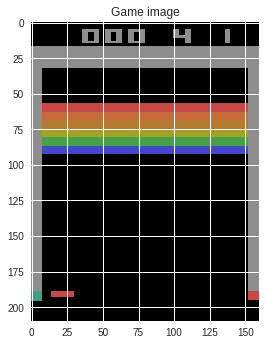

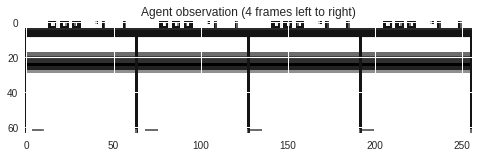

In [6]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0, 2, 1]).reshape([state_dim[0], -1]))

In [0]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [0]:
class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):
        """A simple DQN agent"""
        with tf.variable_scope(name, reuse=reuse):
            self.network = keras.models.Sequential()
            self.network.add(Conv2D(16, (3, 3), strides=2, activation='relu', input_shape=state_shape))
            self.network.add(Conv2D(32, (3, 3), strides=2, activation='relu'))
            self.network.add(Conv2D(64, (3, 3), strides=2, activation='relu'))
            self.network.add(Flatten())
            self.network.add(Dense(256, activation='relu'))
            self.network.add(Dense(n_actions, activation='linear'))
            self.state_t = tf.placeholder('float32', [None, ] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_symbolic_qvalues(self, state_t):
        qvalues = self.network(state_t)
        assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions
        return qvalues

    def get_qvalues(self, state_t):
        sess = tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})

    def sample_actions(self, qvalues):
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [0]:
agent = DQNAgent("dqn_agent", state_dim, n_actions, epsilon=0.5)
sess.run(tf.global_variables_initializer())

In [0]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(
                axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break
        rewards.append(reward)
    return np.mean(rewards)

In [0]:
class ReplayBuffer(object):
    def __init__(self, size):
        self._storage = []
        self._maxsize = size
        self._current = 0
        self._flag = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)
        if self._flag:
            self._storage[self._current] = data
        else:
            self._storage.append(data)
        self._current += 1
        if self._current == self._maxsize:
            self._flag = 1
        self._current %= self._maxsize

    def sample(self, batch_size):
        idxes = [random.randint(0, self.__len__() - 1) for _ in range(batch_size)]
        obs_batch, act_batch, rew_batch, next_obs_batch, done_mask = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs, act, rew, next_obs, done = data
            obs_batch.append(np.array(obs, copy=False))
            act_batch.append(np.array(act, copy=False))
            rew_batch.append(rew)
            next_obs_batch.append(np.array(next_obs, copy=False))
            done_mask.append(done)
        return np.array(obs_batch), np.array(act_batch), np.array(rew_batch), np.array(next_obs_batch), np.array(done_mask)

In [0]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    s = env.framebuffer
    reward = 0
    for i in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        next_s, done, rew, _ = env.step(action)
        reward += rew
        exp_replay.add(s, action, rew, next_s, done)
        s = next_s
        if done:
            s = env.reset()
    return reward

In [0]:
target_network = DQNAgent("target_network", state_dim, n_actions)

In [0]:
def load_weigths_into_target_network(agent, target_network):
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    return assigns

In [15]:
copy_step = load_weigths_into_target_network(agent, target_network)
sess.run(copy_step)

[array([[[[-9.32773277e-02,  1.47750258e-01, -6.05347529e-02,
            2.98604667e-02, -1.09980553e-02,  4.31346595e-02,
            1.58811480e-01,  1.02237165e-02, -1.66936234e-01,
           -2.71906555e-02, -4.89466637e-02,  1.09597236e-01,
           -1.09377906e-01,  1.78830475e-02,  2.48032212e-02,
            1.16941899e-01],
          [-1.69248879e-02,  8.64113867e-03, -3.85323763e-02,
           -9.60095227e-03,  7.11244345e-02,  1.55548066e-01,
           -1.68202192e-01,  6.30101264e-02, -9.54018086e-02,
           -1.01178423e-01,  1.39364481e-01, -1.23848975e-01,
           -7.36036226e-02,  1.61639482e-01,  1.72322780e-01,
           -1.65464342e-01],
          [ 1.44556791e-01,  1.77243918e-01,  1.77848577e-01,
           -2.10137963e-02,  2.98531353e-03, -1.64527074e-01,
            8.03773999e-02,  4.69498932e-02, -1.21573493e-01,
           -1.11942858e-01,  6.62287027e-02, -1.33902013e-01,
           -1.18520319e-01,  5.80579937e-02, -1.50236785e-01,
           -

In [0]:
obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
is_done_ph = tf.placeholder(tf.float32, shape=[None])
is_not_done = 1 - is_done_ph
gamma = 0.99

In [0]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)

In [0]:
next_qvalues_target = target_network.get_symbolic_qvalues(next_obs_ph)
next_state_values_target = tf.reduce_max(next_qvalues_target, axis=-1)
reference_qvalues = rewards_ph + gamma * next_state_values_target * is_not_done
td_loss = (current_action_qvalues - reference_qvalues) ** 2
td_loss = tf.reduce_mean(td_loss)
train_step = tf.train.AdamOptimizer(1e-3).minimize(td_loss, var_list=agent.weights)

In [0]:
sess.run(tf.global_variables_initializer())

In [0]:
moving_average = lambda x, span=100, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(span=span, **kw).mean().values
%matplotlib inline

mean_rw_history = []
td_loss_history = []

In [21]:
exp_replay = ReplayBuffer(10**5)
play_and_record(agent, env, exp_replay, n_steps=10000)

def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph: obs_batch, actions_ph: act_batch, rewards_ph: reward_batch,
        next_obs_ph: next_obs_batch, is_done_ph: is_done_batch
    }

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


buffer size = 24010, epsilon = 0.48515


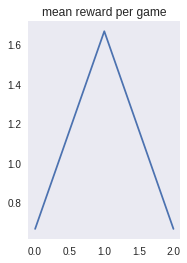

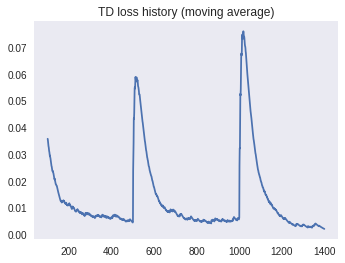

  1%|▏         | 1443/100000 [01:47<1:40:54, 16.28it/s]

In [0]:
for i in trange(10**5):
    play_and_record(agent, env, exp_replay, 10)
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)
    if i % 500 == 0:
        sess.run(copy_step)
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))

    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))
        plt.subplot(1, 2, 1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()
        assert not np.isnan(loss_t)
        plt.figure(figsize=[12, 4])
        plt.subplot(1, 2, 2)
        plt.title("TD loss history (moving average)")
        plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()

In [0]:
assert np.mean(mean_rw_history[-10:]) > 10.
print("That's good enough for tutorial.")